This is a _working_ notebook. See the `ccdControlIntro` notebook for a more narrative how-to. In this notebook, most cells have acquisition, processing, and plotting.

In [1]:
# All system imports
import logging
import time
import clocks
import fitsio

import numpy as np
import scipy
import scipy.optimize as opt

%matplotlib notebook
import matplotlib.pyplot as plt


In [2]:
import power.PCM as PCM
reload(PCM)

pcm = PCM.PCM()
pcm.logger.setLevel(logging.DEBUG)

In [9]:
pcm.powerCmd('fee', True)
pcm.powerCmd('ampSwitch', True)
#pcm.powerCmd('fee', True)


DEBUG:PCM:sending '~13\r\n'
DEBUG:PCM:received 'Success'
DEBUG:PCM:sending '~16\r\n'
DEBUG:PCM:received 'Success'


'Success'

In [4]:
import testing.ampswitch as ampSwitch
reload(ampSwitch)

try:
    switch.close()
except:
    pass

switch = ampSwitch.AmpSwitch(host='10.1.1.21')
switch.readCoils()

[False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False]

In [79]:
# FEE connection and initialization.
# Initialize everything to some sane state.
import fee.feeControl as feeMod
reload(feeMod)

doLoad = False
doCalib = False

fee = feeMod.FeeControl(logLevel=20)
if doLoad:
    fee.sendImage('/home/pfs/feeMain-3.hex')
    time.sleep(3)
else:
    fee.powerUp()
    time.sleep(1)

if not doLoad and doCalib:
    fee.raw('lp,read')
    for channel in 0,1:
        fee.doSet('bias', 'Pp', -1.0, channel=channel) 
        fee.doSet('bias', 'Sp', -1.0, channel=channel)
        fee.doSet('bias', 'Sn', 3.0, channel=channel)
    fee.raw('cal,CDS')
    fee.raw('cal,bias')
    fee.raw('sp,BT1')


SUCCESS
SUCCESS
SUCCESS


In [80]:
t0 = time.time()
stat = fee.getAllStatus()
t1 = time.time()

print "that took %0.3f s" % (t1-t0)

fee.printStatus()


that took 11.700 s
bias.ch0.Pp :  0.00
bias.ch0.Pn :  3.01
bias.ch0.DGp :  4.99
bias.ch0.DGn :  4.99
bias.ch0.Sp :  -1.00
bias.ch0.Sn :  3.01
bias.ch0.SWp :  -6.04
bias.ch0.SWn :  4.99
bias.ch0.RGp :  -7.57
bias.ch0.RGn :  2.01
bias.ch0.OG :  -4.54
bias.ch0.RD :  -1.69
bias.ch0.OD :  -2.88
bias.ch0.BB :  46.59
bias.ch1.Pp :  -1.00
bias.ch1.Pn :  3.01
bias.ch1.DGp :  4.99
bias.ch1.DGn :  4.99
bias.ch1.Sp :  -1.00
bias.ch1.Sn :  3.01
bias.ch1.SWp :  -6.04
bias.ch1.SWn :  4.99
bias.ch1.RGp :  -7.57
bias.ch1.RGn :  2.01
bias.ch1.OG :  -4.54
bias.ch1.RD :  -8.12
bias.ch1.OD :  -19.48
bias.ch1.BB :  28.46
voltage.3V3M :  3.28
voltage.3V3 :  3.25
voltage.5VP :  4.95
voltage.5VN :  -4.90
voltage.5VPpa :  4.95
voltage.5VNpa :  -4.86
voltage.12VP :  11.57
voltage.12VN :  -11.66
voltage.24VN :  -23.03
voltage.54VP :  49.14
offset.ch0.0p :  -24.86
offset.ch0.1p :  0.04
offset.ch0.2p :  0.06
offset.ch0.3p :  0.08
offset.ch0.0n :  0.04
offset.ch0.1n :  0.07
offset.ch0.2n :  0.04
offset.ch0.3n :  0.0

In [67]:
#fee.setSerial('ADC', '03063061')
#fee.setSerial('PA0', '189')


In [68]:
#print fee.raw('gt,ccd0')
#print fee.raw('gt,ccd1')

stat = fee.getAllStatus()
print fee.allKeys('revision')
print 'what'
print fee.doGet('revision')
print 'was that'
print fee.raw('gr,FEE')



DEBUG:root:sending command :'~rb,Pp,ch0\n':
DEBUG:root:received :~rb,Pp,ch0:
DEBUG:root:received :-0.49:
DEBUG:root:sending command :'~rb,Pn,ch0\n':
DEBUG:root:received :~rb,Pn,ch0:
DEBUG:root:received :3.01:
DEBUG:root:sending command :'~rb,DGp,ch0\n':
DEBUG:root:received :~rb,DGp,ch0:
DEBUG:root:received :4.99:
DEBUG:root:sending command :'~rb,DGn,ch0\n':
DEBUG:root:received :~rb,DGn,ch0:
DEBUG:root:received :4.99:
DEBUG:root:sending command :'~rb,Sp,ch0\n':
DEBUG:root:received :~rb,Sp,ch0:
DEBUG:root:received :-1.00:
DEBUG:root:sending command :'~rb,Sn,ch0\n':
DEBUG:root:received :~rb,Sn,ch0:
DEBUG:root:received :3.01:
DEBUG:root:sending command :'~rb,SWp,ch0\n':
DEBUG:root:received :~rb,SWp,ch0:
DEBUG:root:received :-6.03:
DEBUG:root:sending command :'~rb,SWn,ch0\n':
DEBUG:root:received :~rb,SWn,ch0:
DEBUG:root:received :4.99:
DEBUG:root:sending command :'~rb,RGp,ch0\n':
DEBUG:root:received :~rb,RGp,ch0:
DEBUG:root:received :-7.57:
DEBUG:root:sending command :'~rb,RGn,ch0\n':
DEBUG

['FEE']
what


DEBUG:root:sending command :'~gr,FEE\n':
DEBUG:root:received :~gr,FEE:
:



was that
PFS BEE Rev 20150610-01, copyright JHU


In [91]:
switch.close()
del switch

In [23]:
fee.zeroOffsets()
fee.setOffsets(np.arange(8), [-10]*8, leg='p')
fee.setOffsets(np.arange(8), [10]*8, leg='n')

In [60]:
for t in 'revision','serial','voltage':
    print "channels: ", fee.commands[t].channels
    
    for v in fee.allKeys(t):
        print("%s.%s = %s" % (t, v, fee.doGet(t, v)))
    print

for t in 'offset','bias':
    print "channels: ", fee.commands[t].channels

    for ch in 0,1:
        for v in fee.allKeys(t):       
            print("%s.ch%d.%s = %s" % (t, ch, v, fee.doGet(t, v, ch)))
        print
    print




channels:  []
revision.FEE = PFS BEE Rev 20150610-01, copyright JHU

channels:  []
serial.FEE = 3060349
serial.ADC = 3063061
serial.PA0 = 189

channels:  []
voltage.3V3M = 3.28
voltage.3V3 = 3.26
voltage.5VP = 4.95
voltage.5VN = -4.90
voltage.5VPpa = 4.95
voltage.5VNpa = -4.86
voltage.12VP = 11.57
voltage.12VN = -11.67
voltage.24VN = -23.02
voltage.54VP = 49.14

channels:  [0, 1]
offset.ch0.0p = -9.96
offset.ch0.1p = -9.97
offset.ch0.2p = -9.94
offset.ch0.3p = -9.92
offset.ch0.0n = 10.04
offset.ch0.1n = 10.07
offset.ch0.2n = 10.04
offset.ch0.3n = 10.07

offset.ch1.0p = -10.04
offset.ch1.1p = -10.02
offset.ch1.2p = -10.01
offset.ch1.3p = -9.99
offset.ch1.0n = 10.01
offset.ch1.1n = 10.04
offset.ch1.2n = 10.02
offset.ch1.3n = 10.02


channels:  [0, 1]
bias.ch0.Pp = -1.00
bias.ch0.Pn = 3.01
bias.ch0.DGp = 4.99
bias.ch0.DGn = 4.99
bias.ch0.Sp = -1.00
bias.ch0.Sn = 3.01
bias.ch0.SWp = -6.03
bias.ch0.SWn = 4.99
bias.ch0.RGp = -7.57
bias.ch0.RGn = 2.01
bias.ch0.OG = -4.54
bias.ch0.RD = -1.69
b

In [39]:
# FPGA connection and initialization.
# All the reloads are to make sure that new code gets picked up
import fpga as fpgaMod
import fpga.ccdFuncs as ccdFuncs
import fpga.nbFuncs as nbFuncs

reload(fpgaMod)
reload(fpgaMod.ccd)
reload(fpgaMod)

ccd = fpgaMod.CCD(adc18bit=1)  # adc18bit=2 reads the low bits.
ccd.pciReset()
print "FPGA version: 0x%08x" % (ccd.peekWord(0))

FPGA version: 0xbeefa070


In [26]:
# Load the clock tables. pfsClocks is used for each readout.
import clocks_001
import clocks_002
import clocks
reload(clocks_001)
reload(clocks_002)
reload(clocks)

pfsClocks = clocks_002.standardClocks
pre, pix, post = pfsClocks()


In [27]:
reload(nbFuncs)

doGainCurve = False
if doGainCurve:
    fee.zeroOffsets()
    stepSize = 19.9*2
    statCols = slice(5,None)
    amps = np.arange(8)
    noffsets, nlevels = nbFuncs.gainCurve(ccd, fee, amps=amps, stepSize=stepSize, leg='n', 
                                          statCols=statCols, doUnwrap=65000)
    poffsets, plevels = nbFuncs.gainCurve(ccd, fee, amps=amps, stepSize=-stepSize, leg='p', 
                                          statCols=statCols, doUnwrap=65000)
    
    print
    nfits = nbFuncs.plotGains(noffsets, nlevels, amps=amps)
    print
    pfits = nbFuncs.plotGains(poffsets, plevels, amps=amps)

In [17]:
%pdb off
reload(ccdFuncs)
reload(nbFuncs)

allAmps = np.arange(8)
badAmps = []

dummyCcd = False
if not dummyCcd:
    goodAmps = np.arange(8)

    startStep = 5
    levels = 1000
else:
    goodAmps = np.arange(4) + 4
    
    startStep = 10
    levels = np.zeros(8)
    levels[4:] = [10000,25000,20000,15000]

ncols=300

doTune = True
if doTune:
    offs, devs, gains = nbFuncs.tuneLevels(ccd, fee, levels=levels, adjOffset=5, 
                                           amps=goodAmps,
                                           statCols=slice(2,None), 
                                           maxLoops=10, nrows=200, 
                                           startStep=startStep, 
                                           startOffset=startStep,
                                           sigTol=4, 
                                           clockFunc=pfsClocks, 
                                           legs='np', # useGains=nfits[:,0], 
                                           doZero=True, doUnwrap=65000)

    defOffsets = offs
else:
    #defOffsets = np.array([0.014]*8) # np.array([0.0151, 0.0143, 0.0147, 0.0152, 0.0142, 0.0154, 0.0141, 0.0146])
    defOffsets = np.array([0.0188, 0.0189, 0.0426, 0.0424, 0.0193, 0.0193, 0.0433, 0.0402])
    offs = defOffsets
    fee.zeroLevels()
    fee.setLevels(range(8), defOffsets)

Automatic pdb calling has been turned OFF

amps: [0 1 2 3 4 5 6 7]

====== read 0
offs (0): [5.0000 5.0000 5.0000 5.0000 5.0000 5.0000 5.0000 5.0000]
means(0): [499.5506 487.4927 476.1138 517.0773 471.4142 488.3106 495.9917 509.8599]
devs (0): [0.7064 0.7174 0.6970 0.7195 30.3279 30.1737 29.8491 29.8747]
done(0 of 10)   : [0 0 0 0 0 0 0 0]

offs!(0): [10.0000 10.0000 10.0000 10.0000 10.0000 10.0000 10.0000 10.0000]
doffs(0): [5.0000 5.0000 5.0000 5.0000 5.0000 5.0000 5.0000 5.0000]
gains(0): [0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000 0.0000]

====== read 1
offs (1): [10.0000 10.0000 10.0000 10.0000 10.0000 10.0000 10.0000 10.0000]
means(1): [1154.1088 1142.8876 1131.0492 1172.4550 1127.3902 1143.9108 1151.6885 1165.0994]
devs (1): [0.7144 0.7256 0.7007 0.7107 30.2360 30.0539 29.8064 29.7147]
done(1 of 10)   : [0 0 0 0 0 0 0 0]

offs!(1): [8.8610 8.8718 9.0377 8.6462 9.0671 8.8643 8.8814 8.7020]
doffs(1): [-1.1390 -1.1282 -0.9623 -1.3538 -0.9329 -1.1357 -1.1186 -1.2980]
gains(1):

In [88]:
print switch.readCoils()

[True, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False]


0099 1125.8 1061.9 1051.9 1097.6 12446.5 25657.0 9907.3 3137.7 0.71 0.72 0.71 0.73 12034.64 20569.18 12696.31 2243.38 OK
0399 1125.9 1062.5 1052.0 1097.7 7188.4 27846.0 9664.0 2948.3 0.67 0.69 0.69 0.71 7021.76 20001.47 11620.72 2075.44 OK
means: [1125.912 1062.300 1051.966 1097.664 8268.704 26560.831 9994.920 2911.580]
devs:  [0.690 0.733 0.717 0.721 9411.294 20399.998 12587.705 2186.564]
peak:  5170.5 1070 50355 45184.5 150615.0 6.6394449424e-06
file: /data/pfs/2015-06-19/PFSA-00001066.fits


<IPython.core.display.Javascript object>


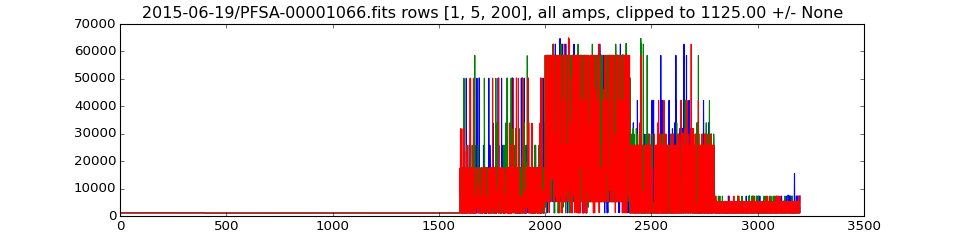

<IPython.core.display.Javascript object>


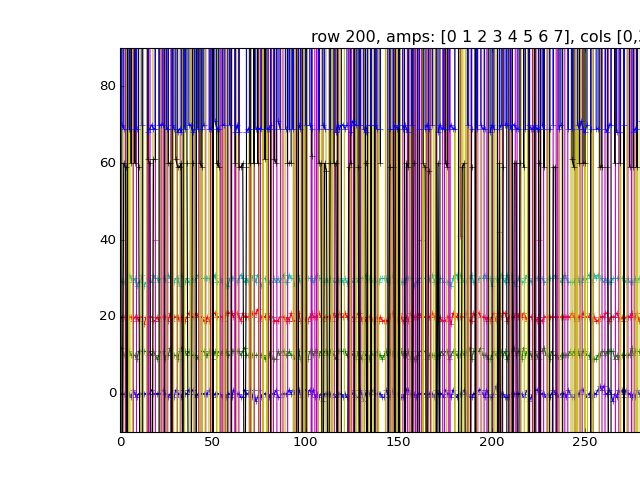

In [37]:
reload(ccdFuncs)
reload(nbFuncs)

reload(clocks_002)
reload(clocks)
pfsClocks = clocks_002.standardClocks

goodAmps = np.arange(8) #[3,4,5,6, 7] # np.arange(8)
badAmps = []

# fee.raw('sb,SWn,ch1,0.0')

nrows = 400                # How many rows to read out.
ncols = 400
selectRows = None #slice(5,None)
selectCols = None # slice(5,5)
pcols = np.arange(0,ncols)    # Which cols to plot
statCols = np.arange(10,ncols) # Which cols to use for stats
prow = (nrows+1)/2
prows = [1, 5, prow]       # which rows to plot
fftAmps = []

figWidth = 12

argDict = dict(everyNRows=500, ampList=goodAmps, cols=statCols, ccd=ccd)

siggenAmp = None
if siggenAmp is None:
    switch.setCoils(off=range(16))
else:
    switch.chooseCoil(siggenAmp)

flushRead = True
doFile = None # '/data/pfs/2015-06-02/PFSA-00000954.fits'
if doFile:
    im = fitsio.read(doFile)
else:
    
    if flushRead:
        im, files = ccd.readImage(nrows=100, ncols=ncols, 
                                  rowFunc=ccdFuncs.rowStats, rowFuncArgs=argDict, 
                                  clockFunc=pfsClocks, doSave=False)
    im, files = ccd.readImage(nrows=nrows, ncols=ncols, 
                              rowFunc=ccdFuncs.rowStats, rowFuncArgs=argDict, 
                              clockFunc=pfsClocks, doSave=True)
if selectRows is not None:
    im = im[selectRows]
if selectCols is not None:
    im = im[:,selectCols]
    
im = im.astype('i4')
hi_w = np.where(im > 65500)
im[hi_w] -= 65535

if siggenAmp is None:
    amp4Mask = ccd.ampidx(4, im)
else:
    amp4Mask = ccd.ampidx(siggenAmp, im)

#amp6Mask = ccd.ampidx(6, im)
#im[:, amp6Mask] -= im[:, amp6Mask].mean()
#im[:, amp6Mask] += im[:, ccd.ampidx(4, im)].mean()

means,devs = nbFuncs.ampStats(im, ccd=ccd, cols=statCols)
print "means:", nbFuncs.fmtArr(means, format="%0.3f")
print "devs: ", nbFuncs.fmtArr(devs, format="%0.3f")
med4 = np.median(im[prow, amp4Mask])
max4 = np.max(im[prow, amp4Mask])
min4 = np.min(im[prow, amp4Mask])

inject = 0.3
print "peak: ", med4, min4, max4, max4-med4, (max4-med4)/inject, inject/(max4-med4)

# print "shape: %s dtype: %s" % (str(im.shape), im.dtype)
    
if len(files) > 0:
    path = files[0]
    imName = '/'.join(path.split('/')[-2:])
    print "file: %s" % (path)

#focusAmp = 0             # Which amp to focus on
#focusMask = ccd.ampidx(focusAmp, im)[pcols]

# plot one or more rows across the entire image
nbFuncs.plotRows(im, prows, imName=imName, figWidth=figWidth, pixRange=200 if siggenAmp is not None else None)

# plot one row for each the "good" amps
peaks = None # np.arange(1, ncols, 50)
if siggenAmp is not None:
    channel = siggenAmp/4
    amps0 = [siggenAmp]
    amps1 = goodAmps[np.where((goodAmps/4 == channel) & (goodAmps != siggenAmp))]
    amps2 = goodAmps[np.where(goodAmps/4 != channel)]

    nbFuncs.plotAmps(im, amps=amps0, row=prow, cols=pcols, 
                 plotOffset=10, fig=None, figWidth=figWidth, 
                 peaks=peaks, clipPeaks=True)

    nbFuncs.plotAmps(im, amps=amps1, row=prow, cols=pcols, 
                 plotOffset=100, fig=None, figWidth=figWidth, 
                 peaks=peaks, clipPeaks=True)

    nbFuncs.plotAmps(im, amps=amps2, row=prow, cols=pcols, 
                 plotOffset=10, fig=None, figWidth=figWidth)
else:
    f = None # plt.figure('plotAmps')
    nbFuncs.plotAmps(im, amps=goodAmps, row=prow, cols=pcols, 
                     plotOffset=10, fig=f, figWidth=figWidth, 
                     peaks=peaks, clipPeaks=True)

# f.axes[0].set_ylim(-50, 150)

# plot any bad amps individually
for a in badAmps:
    nbFuncs.plotAmps(im, amps=[a], row=prow, cols=pcols, figWidth=figWidth)

# show a grid of histograms.
hists = nbFuncs.ampHistGrid(im, ccd, cols=pcols, histRange=20, figWidth=figWidth)

# show a grid of raw amp images.
nbFuncs.rawAmpGrid(im, ccd, cols=pcols, figWidth=figWidth, showFfts=True)

fftAmps = [] # np.arange(8) # [1,2,5] # [5,6]
if len(fftAmps) > 0:    
    
    fftFig = plt.figure(figsize=(figWidth, figWidth/4))
    for a in fftAmps:
        fftFig = plt.figure(figsize=(figWidth, figWidth/4))
        fftMask = ccd.ampidx(a, im)[pcols]
        ampSeg = im[prow,fftMask]
        freqs, fft, peak_ii = ccdFuncs.plotTopPeriods(ampSeg, topN=3)


#fig.colorbar(pp)
#plt.tight_layout()